In [35]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import os, json
import numpy as np
import json
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter


# contants
WORD_EMBEDDING_DIMENSIONALITY = 300
UTTERANCE_DIMENSIONALITY = 300
MAX_TURNS = 21

num_to_label = {0:'NB', 1:'PB', 2:'B', 3:'U'}
label_to_num = {'NB':0, "PB":1, 'B':2, 'U':3}

NB_LABELS = len(num_to_label)

## Utils

In [54]:
#####################################
# file path -> array
#####################################
def json_file_path_to_array(json_file_path):
    '''Takes path to json file and return its dialogue as an array of turns'''
    with open(json_file_path) as json_f:
        d = json.load(json_f)
    parsed = []
    def parse_turn(turn):
        '''parse turn, separate utterances and labels'''
        utterance = turn['utterance']
        if not turn['annotations']:
            return utterance
        else:
            breakdown_l = [annotation['breakdown'] for annotation in turn['annotations']]
            return (utterance, breakdown_l)    
    for t in d['turns']:
        parsed.append(parse_turn(t))
    return parsed

#####################################
# array of labels -> score
#####################################
def dialogue_array_score(dialogue):
    '''Tranform 30 labels of each system response into one majority score'''
    # print('scoring labels of the dialogue - ', dialogue)
    for i, turn in enumerate(dialogue):
        if isinstance(turn, tuple):
            local_turn, labels = dialogue[i]
            NB = labels.count('O')
            PB = labels.count('X')
            B = labels.count('T')
            counts_array = np.array([NB, PB, B])
            final_label = np.argmax(counts_array)
            dialogue[i] = (local_turn, final_label)
    return dialogue


# separate labels and utterances
def separate_turns_labels(dialogue):
    '''takes a dialogue array with labelled system responses as an input and
    returns arrays of its utterances and corresponding labels'''
    utterances = []
    labels = []
    for t in dialogue:
        if isinstance(t,tuple):
            # system turn
            utterances.append(t[0])
            labels.append(t[1])
        else:
            # user turn
            utterances.append(t)
            labels.append(label_to_num['U'])
    return utterances, labels


def tokens_replacement(tokens):
    '''
    the function replaces some of the contractions with an apostrophe with more appropariate counterparts
    '''
    replacement_dict = dict({
    "That's": 'That is',
    "that's": 'that is',
    "What's": 'What is',
    "what's": 'what is',
    "Let's": 'Lets',
    "let's": 'lets',
    "that's": 'that is',
    "You're": 'You are',
    "you're": 'you are',
    "i'm": "I'm",
    "isn't": "is not",
    "haven't": "have not",
    "wasn't": "was not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "there's": "there is",
    "They're": "They are",
    "they're": "they're",
    "we're": "we are"
    })
    
    for i, token in enumerate(tokens):
        if token in replacement_dict:
            del tokens[i]
            replacement = TweetTokenizer().tokenize(replacement_dict[token])
            tokens.extend(replacement)
    return tokens


def text_preprocessing(utterance):
    '''takes utterance, tokenizes it and removes punctuation
    returns list of tokens'''
    # tokenize
    tokenizer = TweetTokenizer(preserve_case = True)
    tokens = tokenizer.tokenize(utterance)
    # remove punctuation
    punctuation_signs = ['.', ',', '!', '?', ',', ':', '"', "'", '...', '’', '-', '–', ')', '(', '…', '”', '/']
    tokens = [word for word in tokens if word not in punctuation_signs]
    # fix hyphenation
    tokens = tokens_replacement(tokens)
    # replace i'm -> I'm
    if "i'm" in tokens:
        tokens = ["I'm" if token == "i'm" else token for token in tokens]
    
    # lowercase <- only relevant for twitter embedding
    # tokens = [word.lower() for word in tokens]
    return tokens


def utterance_emb(utterance_tokens):
    '''the function takes utterance tokens as an input and returns utterance embedding'''
    # embedd each word
    word_embeddings = []
    for token in utterance_tokens:
        try:
            word_embeddings.append(model[token])
        except:
            # unk token
            UNK_TOKENS.append(token)
            word_embeddings.append(model['unk'])    
    # get utterance representation  
    utterance_embedding = np.zeros(shape=(UTTERANCE_DIMENSIONALITY,))
    # sum up embeddings if turn is non empty
    if len(word_embeddings) > 0:
        # sum embeddings over
        for emb in word_embeddings:
            utterance_embedding += emb
        utterance_embedding = utterance_embedding/len(word_embeddings)
    return utterance_embedding

# dialogue represenation
def turns_to_dialogue_emb(turns):
    '''the function takes array of turns and returns dialogue mebedding'''
    dialogue_embedding = np.empty(shape = 0)
    counter = 1
    for t in turns:
        preprocessed_tokens = text_preprocessing(t)
        utterance_embedding = utterance_emb(preprocessed_tokens)
        dialogue_embedding = np.concatenate((dialogue_embedding, utterance_embedding), axis = 0)
        counter += 1
    # padding
    if len(turns) < 21:
        dialogue_embedding = np.concatenate((dialogue_embedding, np.zeros(shape = (WORD_EMBEDDING_DIMENSIONALITY,))))
    # reshape dialogue
    dialogue_embedding = dialogue_embedding.reshape(-1, WORD_EMBEDDING_DIMENSIONALITY)
    return dialogue_embedding


#--------------------------------------------------
# process dialogue labels
#--------------------------------------------------
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])


def labels_encode(labels):
    labels_embedding = get_one_hot(np.array(labels), NB_LABELS)
    # padding: 
    if labels_embedding.shape[0] < 21:
        pad = np.zeros(shape=(1,NB_LABELS))
        labels_embedding = np.concatenate((labels_embedding, pad))
    return labels_embedding


#--------------------------------------------------
# training history analysis
#--------------------------------------------------
def print_history(history):
    return 'val loss - {}, val acc - {},\neval loss - {}, eval acc - {}'.format(history.history['val_loss'][-1], history.history['val_acc'][-1], history.history['loss'][-1], history.history['acc'][-1])


import matplotlib.pyplot as plt
def plot_accuracy(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



def pred_tensor_to_labels(labels_tensor):
    '''the function takes a tensor of one-hot encoded dialogue labels and returns an array of labels'''
    labels = []
    for dialogue_labels in labels_tensor:
        for turn in dialogue_labels:
            label = num_to_label[np.argmax(turn)]
            labels.append(label)
    return labels



# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    
# plot normalized confusion matrix
def cnf_matrix(labels_true, labels_pred, labels):
    labels_array = np.array(labels)
    cnf_matrix = confusion_matrix(labels_true, labels_pred)
    # labels_array = np.array(['NB', 'PB', 'B'])

    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=labels_array, normalize=True,
                          title='Normalized confusion matrix')

def clf_report(labels_true, labels_pred): 
    # plot classification report
    print('Classification report for eval data:\n', classification_report(labels_true, labels_pred))

## dataset preprocessing

In [55]:
# generate pathes to the datasets
base_path = "../dbdc/"

CIC_115_dev = base_path + 'dev/' + 'CIC_115'
IRIS_100_dev = base_path + 'dev/' + 'IRIS_100'
TKTK_100_dev = base_path + 'dev/' + 'TKTK_100'
YI_100_dev = base_path + 'dev/' + 'YI_100'

dev_datasets_pathes = [CIC_115_dev, IRIS_100_dev, TKTK_100_dev, YI_100_dev]

CIC_50_eval = base_path + 'eval/' + 'CIC_50'
IRIS_50_eval = base_path + 'eval/' + 'IRIS_50'
TKTK_50_eval = base_path + 'eval/' + 'TKTK_50'
YI_50_eval = base_path + 'eval/' + 'YI_50'

eval_datasets_pathes = [CIC_50_eval, IRIS_50_eval, TKTK_50_eval, YI_50_eval]


# collect pathes to dev files
dev_files_pathes = []
for dataset_path in dev_datasets_pathes:
    print('processing dataset - ', dataset_path)
    for i in os.listdir(dataset_path):
        path = dataset_path + '/' + i
        dev_files_pathes.append(path)
        
# collect pathes to eval files
eval_files_pathes = []
for dataset_path in eval_datasets_pathes:
    print('processing dataset - ', dataset_path)
    for i in os.listdir(dataset_path):
        path = dataset_path + '/' + i
        eval_files_pathes.append(path)

print('Dev set contains {} dialogues'.format(len(dev_files_pathes)))
print('Eval set contains {} dialogues'.format(len(eval_files_pathes)))

processing dataset -  ../dbdc/dev/CIC_115
processing dataset -  ../dbdc/dev/IRIS_100
processing dataset -  ../dbdc/dev/TKTK_100
processing dataset -  ../dbdc/dev/YI_100
processing dataset -  ../dbdc/eval/CIC_50
processing dataset -  ../dbdc/eval/IRIS_50
processing dataset -  ../dbdc/eval/TKTK_50
processing dataset -  ../dbdc/eval/YI_50
Dev set contains 415 dialogues
Eval set contains 200 dialogues


In [56]:
# getting list of dev dialogues
dev_dialogues = []
for path in dev_files_pathes:
    dialogue = json_file_path_to_array(path)
    scored_dialogue = dialogue_array_score(dialogue)
    dev_dialogues.append(scored_dialogue)

# getting list of eval dialogues
eval_dialogues = []
for path in eval_files_pathes:
    dialogue = json_file_path_to_array(path)
    scored_dialogue = dialogue_array_score(dialogue)
    eval_dialogues.append(scored_dialogue)

In [57]:
eval_labels = []
for dialogue in eval_dialogues:
    _, labels = separate_turns_labels(dialogue)
    eval_labels.extend(labels)
    
labels_counter_eval = Counter(eval_labels)
labels_counter_eval

Counter({3: 2098, 1: 499, 2: 745, 0: 756})

## loading word2vec

In [58]:
# load model
model = gensim.models.KeyedVectors.load_word2vec_format('../models/GoogleNews300.bin', binary=True, unicode_errors='ignore')

## tensors prep

In [61]:
# prepare dev tensors: input and target
dev_input = np.array([]).reshape(-1,WORD_EMBEDDING_DIMENSIONALITY)
dev_target = np.array([]).reshape(-1,NB_LABELS)
#-----------------------------------------

UNK_TOKENS = []
# dev dialogues
counter = 1
for dialogue in dev_dialogues:
    # unpack turns and labels
    turns, labels = separate_turns_labels(dialogue)
    # get dialogue emb
    dialogue_emb = turns_to_dialogue_emb(turns)
    # concat dialogue emb to the dev_input tensor
    dev_input = np.concatenate((dev_input, dialogue_emb))
    # get labels embedding
    lables_emb = labels_encode(labels)
    # concat labels emb to the dev_target tensor
    dev_target = np.concatenate((dev_target, lables_emb))
    counter += 1

In [62]:
# reshape dev input and dev target tensors
X_train = dev_input.reshape(-1,21,UTTERANCE_DIMENSIONALITY)
y_train = dev_target.reshape(-1,21,NB_LABELS)

# check the shapes
print('X_train shape - {}, y_train shape - {}'.format(X_train.shape, y_train.shape))

X_train shape - (415, 21, 300), y_train shape - (415, 21, 4)


In [64]:
# prepare eval tensors: input and target
eval_input = np.array([]).reshape(-1,WORD_EMBEDDING_DIMENSIONALITY)
eval_target = np.array([]).reshape(-1,NB_LABELS)
#-----------------------------------------

# eval dialogues
counter = 1
for dialogue in eval_dialogues:
    # unpack turns and labels
    turns, labels = separate_turns_labels(dialogue)
    # get dialogue emb
    dialogue_emb = turns_to_dialogue_emb(turns)
    # concat dialogue emb to the dev_input tensor
    eval_input = np.concatenate((eval_input, dialogue_emb))
    # get labels embedding
    lables_emb = labels_encode(labels)
    # concat labels emb to the dev_target tensor
    eval_target = np.concatenate((eval_target, lables_emb))
    counter += 1

In [65]:
# reshape eval input and eval target tensors
X_test = eval_input.reshape(-1,21,UTTERANCE_DIMENSIONALITY)
y_test = eval_target.reshape(-1,21,NB_LABELS)

# check the shapes
print('X_test shape - {}, y_test shape - {}'.format(X_test.shape, y_test.shape))

X_test shape - (200, 21, 300), y_test shape - (200, 21, 4)


In [66]:
# checking nans and infs in the embeddings
dataset = [X_train, y_train, X_test, y_test]
for subset in dataset:
    for datapoint in subset:
        if np.isnan(datapoint).any():
            print(subset, ' has nan values!')
        if np.isinf(datapoint).any():
            print(subset, ' has inf values!')

In [67]:
# checking unk tokens
unk_bow = Counter(UNK_TOKENS)
print(unk_bow.most_common(50))
print('the embedding model doesnt know {} tokens, {} out of them unique'.format(len(UNK_TOKENS), len(set(UNK_TOKENS))))

[('to', 1988), ('a', 1776), ('of', 796), ('and', 510), (':(', 161), (';(', 72), ('\\', 65), ('..', 31), ('50', 30), ('Uh-huh', 24), ("How's", 17), ('renato', 14), ("She's", 11), ('umbria', 11), ('Https', 10), ('perugia', 9), ("i've", 8), ('altopana', 8), ('42', 7), ('1995', 7), ('travelling', 7), ("Where's", 7), (';', 7), ('cavuto', 6), ('40', 6), ('10', 6), ('ConvAI', 6), ('Чо', 6), ('13', 6), ('1960s', 6), ('camelia', 5), ('www.youtube.com/watch', 5), ("Aren't", 5), ('100', 5), ('questionHow', 4), ('25', 4), ('35', 4), ('20', 4), ('10,000', 4), ('2005', 4), ('17', 4), ("Man's", 4), ('hormuud', 4), ('Whazzup', 4), ('Aquestionaboutthepassage', 4), ('1953', 4), ('werner', 4), ('Maintenence', 4), ('forbo', 4), ('Pellit', 4)]
the language model doesnt know 6480 tokens, 600 out of them unique


# building the models

In [16]:
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Activation, TimeDistributed
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pydot

Using TensorFlow backend.


In [17]:
#####################################
# model 1 - vanilla
#####################################
vanilla = Sequential()
# input layer - lstm
lstm1 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
vanilla.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
dense1 = Dense(64, activation = 'relu')
vanilla.add(dense1)
# dense 2
dense2 = Dense(64, activation = 'relu')
vanilla.add(dense2)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
vanilla.add(outputs)
vanilla.summary()

vanilla.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

vanilla_history = vanilla.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 64)            93440     
_________________________________________________________________
dense_1 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_2 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_3 (Dense)              (None, 21, 4)             260       
Total params: 102,020
Trainable params: 102,020
Non-trainable params: 0
_________________________________________________________________
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 3s 7ms/step - loss: 1.2200 - acc: 0.4799 - val_loss: 1.2562 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] - 1s 2ms/step - loss: 1.1676 - acc: 

In [18]:
#####################################
# model 2 - stacked
#####################################
stacked = Sequential()
# input layer - lstm
lstm1 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
stacked.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
lstm2 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
stacked.add(lstm2)
# dense 3
dense3 = Dense(64, activation = 'relu')
stacked.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
stacked.add(outputs)
print('Stacked lstm:\n')
print(stacked.summary())

# compile
stacked.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
print('Model compiled')

# fit
stacked_history = stacked.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

Stacked lstm:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 64)            93440     
_________________________________________________________________
lstm_3 (LSTM)                (None, 21, 64)            33024     
_________________________________________________________________
dense_4 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_5 (Dense)              (None, 21, 4)             260       
Total params: 130,884
Trainable params: 130,884
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 6s 13ms/step - loss: 1.2416 - acc: 0.4779 - val_loss: 1.2792 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] 

In [19]:
#####################################
# model 3 - bidirectional
#####################################
from keras.layers import Bidirectional

bi_lstm = Sequential()
# input layer - bi-lstm
lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1),
                        input_shape=(21, UTTERANCE_DIMENSIONALITY),
                    merge_mode = 'sum')
bi_lstm.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
dense1 = Dense(64, activation = 'relu')
bi_lstm.add(dense1)
# dense 2
dense3 = Dense(64, activation = 'relu')
bi_lstm.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
bi_lstm.add(outputs)
bi_lstm.build()
print('Bi-lstm:\n')
print(bi_lstm.summary())

# compile
bi_lstm.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
print('Model compiled')

# fit
bi_lstm_history = bi_lstm.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

Bi-lstm:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 21, 64)            186880    
_________________________________________________________________
dense_6 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_7 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_8 (Dense)              (None, 21, 4)             260       
Total params: 195,460
Trainable params: 195,460
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 5s 12ms/step - loss: 1.2061 - acc: 0.4757 - val_loss: 1.2259 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] - 1s 

## evaluation

Vanilla lstm:


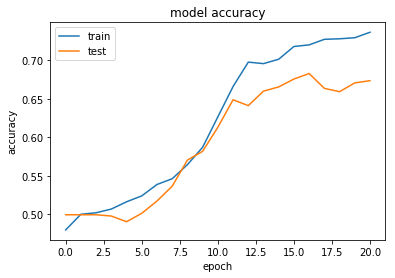

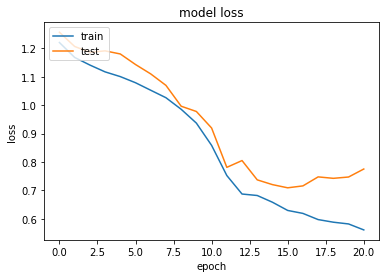

In [20]:
print('Vanilla lstm:')
plot_accuracy(vanilla_history)
plot_loss(vanilla_history)

Stacked lstm:


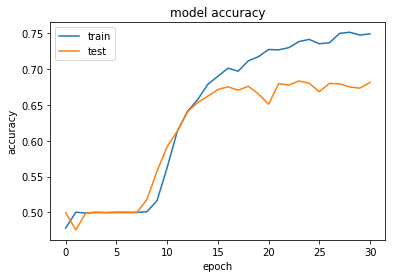

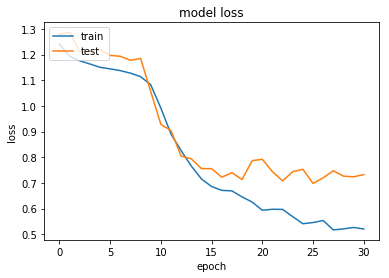

In [21]:
print('Stacked lstm:')
plot_accuracy(stacked_history)
plot_loss(stacked_history)

Bi lstm:


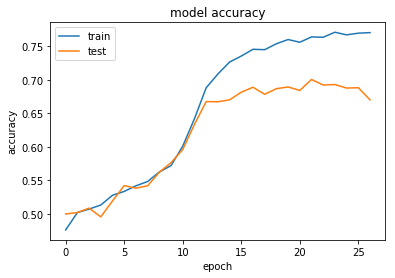

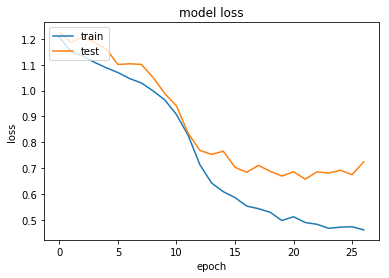

In [22]:
print('Bi lstm:')
plot_accuracy(bi_lstm_history)
plot_loss(bi_lstm_history)

In [23]:
from sklearn.metrics import classification_report

labels_true = pred_tensor_to_labels(y_test)
# vanilla
y_pred_vanilla = vanilla.predict(X_test)
labels_pred_vanilla = pred_tensor_to_labels(y_pred_vanilla)
# stacked
y_pred_stacked = stacked.predict(X_test)
labels_pred_stacked = pred_tensor_to_labels(y_pred_stacked)
# bilstm
y_pred_bi_lstm = bi_lstm.predict(X_test)
labels_pred_bi_lstm = pred_tensor_to_labels(y_pred_bi_lstm)

In [24]:
# removing U label for accuracy measures
true_labels_no_U = []
vanilla_pred_no_U = []
stacked_pred_no_U = []
bi_lstm_pred_no_U = []
for true_label, pred_vanilla, pred_stacked, pred_bi_lstm in zip(labels_true, labels_pred_vanilla, labels_pred_stacked, labels_pred_bi_lstm):
    if true_label != 'U':
        true_labels_no_U.append(true_label)
        vanilla_pred_no_U.append(pred_vanilla)
        stacked_pred_no_U.append(pred_stacked)
        bi_lstm_pred_no_U.append(pred_bi_lstm)

In [25]:
# ACCURACY
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# counted only for NB, PB, B true labels (U label is omitted)
acc_vanilla = accuracy_score(true_labels_no_U, vanilla_pred_no_U)
acc_stacked = accuracy_score(true_labels_no_U, stacked_pred_no_U)
acc_bi_lstm = accuracy_score(true_labels_no_U, bi_lstm_pred_no_U)
print("Accuracies:\nvanilla - {},\n stacked - {},\n bi-lstm - {}".format(acc_vanilla, acc_stacked, acc_bi_lstm))

Accuracies:
vanilla - 0.4077069457659372,
 stacked - 0.41246431969552805,
 bi-lstm - 0.39200761179828736


vanilla model:

Normalized confusion matrix
[[0.2  0.35 0.34 0.1 ]
 [0.07 0.48 0.27 0.17]
 [0.04 0.3  0.58 0.08]
 [0.   0.02 0.04 0.94]]


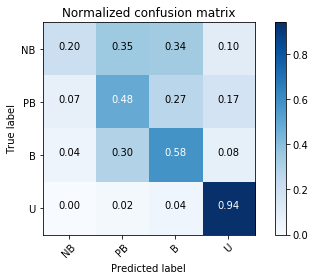

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.64      0.20      0.31       745
          NB       0.50      0.48      0.49       858
          PB       0.37      0.58      0.46       499
           U       0.00      0.00      0.00         0

   micro avg       0.41      0.41      0.41      2102
   macro avg       0.38      0.32      0.31      2102
weighted avg       0.52      0.41      0.42      2102



/home/mariya/software/anaconda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [27]:
print('vanilla model:\n')
print(cnf_matrix(labels_true, labels_pred_vanilla, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, vanilla_pred_no_U)

stacked model:

Normalized confusion matrix
[[0.19 0.3  0.39 0.11]
 [0.06 0.41 0.36 0.17]
 [0.02 0.21 0.67 0.09]
 [0.   0.01 0.05 0.93]]


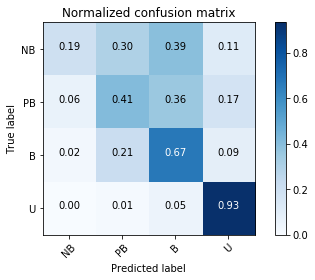

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.68      0.19      0.30       745
          NB       0.52      0.41      0.46       858
          PB       0.36      0.67      0.47       499
           U       0.00      0.00      0.00         0

   micro avg       0.39      0.39      0.39      2102
   macro avg       0.39      0.32      0.31      2102
weighted avg       0.54      0.39      0.40      2102



In [43]:
print('stacked model:\n')
print(cnf_matrix(labels_true, labels_pred_stacked, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, stacked_pred_no_U)

bi lstm model:

Normalized confusion matrix
[[0.22 0.43 0.28 0.07]
 [0.07 0.57 0.23 0.13]
 [0.03 0.38 0.48 0.11]
 [0.   0.03 0.03 0.94]]


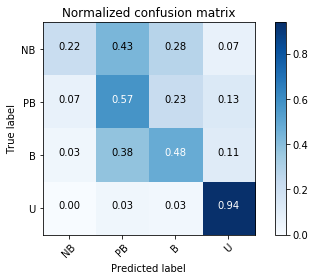

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.68      0.22      0.33       745
          NB       0.49      0.57      0.53       858
          PB       0.37      0.48      0.42       499
           U       0.00      0.00      0.00         0

   micro avg       0.42      0.42      0.42      2102
   macro avg       0.39      0.32      0.32      2102
weighted avg       0.53      0.42      0.43      2102



In [44]:
print('bi lstm model:\n')
print(cnf_matrix(labels_true, labels_pred_bi_lstm, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, bi_lstm_pred_no_U)